In [1]:

## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from dataLoader import getDatasetForTCN, getDatasetForTCN2
from torchsummary import summary

# torch.manual_seed(43)  # for reproducibility


Files to render: 3


In [2]:
# Net 1 train file type = 120
# Currently parsing file: L5PC_sim__Output_spikes_0729__Input_ranges_Exc_[0119,1138]_Inh_[0041,1296]_per100ms__simXsec_128x6_randseed_800102.p
train_data, test_data = getDatasetForTCN(120)




Currently parsing file: L5PC_sim__Output_spikes_0729__Input_ranges_Exc_[0119,1138]_Inh_[0041,1296]_per100ms__simXsec_128x6_randseed_800102.p
(1, 1278, 720000)
Done, time elapsed: 14.671 

length 612000
1530
length 108000
270


In [3]:
count = 0
print(train_data.__len__())
for batch in train_data:
    count+=1
    if count > 50:
        break
print(count)

1530
51


In [4]:

## Helper Functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

BATCH_SIZE = 28
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=0)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4)


device = get_default_device()

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(test_dl, device)


In [5]:
mse_loss = nn.MSELoss()


def round(x, decimals=0):
    b = 10**decimals
    return torch.round(x*b)/b


count = 0

def accuracy(outputs, labels):
#     print("Output shape", outputs.shape)
    preds, _ = torch.max(outputs, dim=1)
    preds = torch.flatten(preds)
   
    labels = torch.flatten(labels)
    labels = round(labels, decimals=0)
    preds =  round(preds, decimals=0)
#     print("Label shape", labels.shape)
#     print("Prediction Shape", preds.shape)
#     print("Length", len(preds))
#     print(torch.tensor(torch.sum(preds == labels).item()))
#     preds.get()
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




class BaseModule(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        outM = torch.flatten(out)
        labelsM = torch.flatten(labels)
        loss = mse_loss(outM, labelsM) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        outM = torch.flatten(out)
        labelsM = torch.flatten(labels)
        loss = mse_loss(outM, labelsM)
        acc = accuracy(out, labels)        
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def train_val_step(self, batch):
        images, labels = batch
        out = self(images)      
        loss = mse_loss(out, labels)
        acc = accuracy(out, labels)        
        return {'train_loss': loss.detach(), 'train_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print("Epoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))
        

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []

    if opt_func == torch.optim.SGD:
        optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    else:
        optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def plotResults(history,name):
    losses = [entry['val_loss'] for entry in history]
    accuracy = [entry["val_acc"] for entry in history]
    train_loss = [entry["train_loss"] for entry in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Model Results')

    ax1.plot(losses, '-o', label="Validation Loss")
    ax1.plot(train_loss, "-s", label="Training Loss")
    ax1.legend()
#     ax1.set_ylim([0,5])
    ax1.set(xlabel = 'Epoch', ylabel="Loss")

    
    ax2.set(xlabel = 'Epoch', ylabel="Values")
    ax2.plot(accuracy, "-r")

    # plt.legend()
    ax1.set_title('Loss vs. Number of Epochs');
    ax2.set_title("Top 1% Accuracy on Validation Set");
    plt.savefig("{}-results.png".format(name))
    plt.show()

    
histories = []

In [6]:

class CausalConv1d(nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result
    

class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            CausalConv1d(in_channels=1278, out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=32, kernel_size=7, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=32, kernel_size=24, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=1, kernel_size=33, stride=1, dilation=1, groups=1, bias=True),
        )
    def forward(self, x):
        x = x.float()
#         print("Input shape", x.shape)
        res = self.net(x)
        temp = res[:,:, 150:]

        return temp.to(dtype=torch.float64)




Epoch 1, Validation Loss: 18.5893, Validation Accuracy: 0.0784
Epoch 2, Validation Loss: 6.4208, Validation Accuracy: 0.1412
Epoch 3, Validation Loss: 4.9151, Validation Accuracy: 0.1805
Epoch 4, Validation Loss: 3.7021, Validation Accuracy: 0.2485
Epoch 5, Validation Loss: 3.2361, Validation Accuracy: 0.2685
Epoch 6, Validation Loss: 3.0065, Validation Accuracy: 0.2787
Epoch 7, Validation Loss: 2.8419, Validation Accuracy: 0.2885
Epoch 8, Validation Loss: 2.7127, Validation Accuracy: 0.3020
Epoch 9, Validation Loss: 2.6554, Validation Accuracy: 0.3339
Epoch 10, Validation Loss: 2.6501, Validation Accuracy: 0.3646


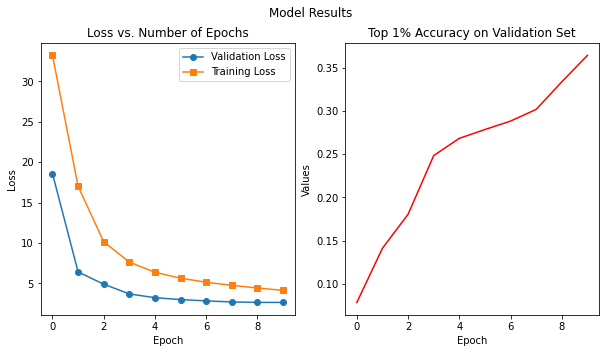

In [7]:


model = to_device(Net1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 9e-5
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net1")

In [28]:

truth = []
preds = []

with torch.no_grad():
    count = 0
    lim = 15
    for batch in train_dl:
        res = model(batch[0].to("cuda"))
        res = res[:,0,:]
        res = torch.flatten(res)
        preds+= res.tolist()
        
        truthVals = batch[1]
        truthVals = torch.flatten(truthVals)
        truth+= truthVals.float()
        count+=1

        if count > lim:
            break
    

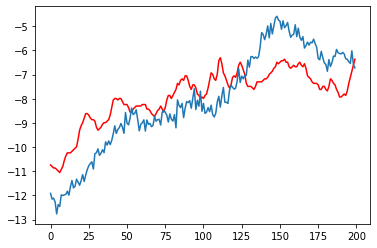

In [29]:
plt.figure()
plt.plot(truth[:200], "-r")
plt.plot(preds[:200])
plt.show()

In [30]:

import numpy as np
a = np.array(preds[:90000], dtype=np.float16)
a.tofile('outputTCN6.csv', sep=',')


In [10]:
class Net2(BaseModule):
    def __init__(self):
        super(Net2, self).__init__()

        self.net = nn.Sequential(
            CausalConv1d(in_channels=1278, out_channels=64, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=64, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=64, out_channels=64, kernel_size=7, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=64, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=64, out_channels=64, kernel_size=20, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=64, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=64, out_channels=1, kernel_size=33, stride=1, dilation=1, groups=1, bias=True),
        )
    def forward(self, x):
        x = x.float()
#         print("Input shape", x.shape)
        res = self.net(x)
        temp = res[:,:, 150:]

        return temp.to(dtype=torch.float64)


Epoch 1, Validation Loss: 12.9513, Validation Accuracy: 0.1092
Epoch 2, Validation Loss: 4.6269, Validation Accuracy: 0.3145
Epoch 3, Validation Loss: 3.7327, Validation Accuracy: 0.2327
Epoch 4, Validation Loss: 3.3288, Validation Accuracy: 0.2510
Epoch 5, Validation Loss: 3.0903, Validation Accuracy: 0.2557
Epoch 6, Validation Loss: 2.8803, Validation Accuracy: 0.2677
Epoch 7, Validation Loss: 2.7591, Validation Accuracy: 0.2806
Epoch 8, Validation Loss: 2.6859, Validation Accuracy: 0.3114
Epoch 9, Validation Loss: 2.6564, Validation Accuracy: 0.3418


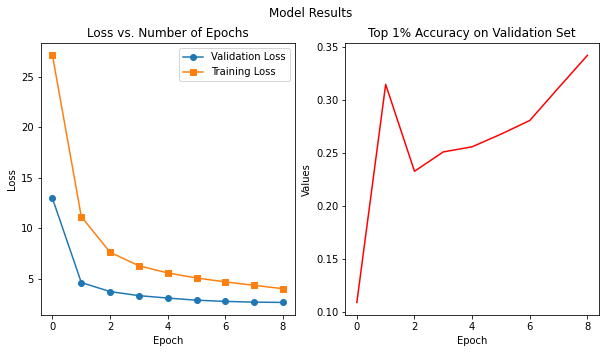

In [11]:


model = to_device(Net2(), device)
history = [evaluate(model, val_loader)]
num_epochs = 9
opt_func = torch.optim.Adam
lr = 7e-5
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net2")

In [13]:

truth = []
preds = []

with torch.no_grad():
    count = 0
    lim = 15
    for batch in train_dl:
        res = model(batch[0].to("cuda"))
        res = res[:,0,:]
        res = torch.flatten(res)
        preds+= res.tolist()
        
        truthVals = batch[1]
        truthVals = torch.flatten(truthVals)
        truth+= truthVals.float()
        count+=1

        if count > lim:
            break


    

112000


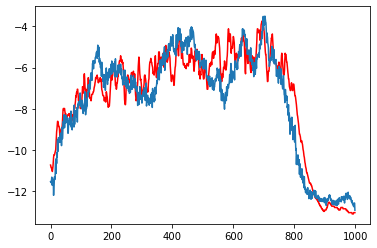

In [16]:
print(len(preds))
plt.figure()
plt.plot(truth[:1000], "-r")
plt.plot(preds[:1000])
plt.show()

In [17]:
            
import numpy as np
a = np.array(preds[:90000], dtype=np.float16)
a.tofile('outputTCN3.csv',sep=',')

Epoch 1, Validation Loss: 7.6292, Validation Accuracy: 0.1283
Epoch 2, Validation Loss: 3.4396, Validation Accuracy: 0.2477
Epoch 3, Validation Loss: 2.6991, Validation Accuracy: 0.3071
Epoch 4, Validation Loss: 2.3914, Validation Accuracy: 0.3910
Epoch 5, Validation Loss: 2.2504, Validation Accuracy: 0.4045
Epoch 6, Validation Loss: 2.1780, Validation Accuracy: 0.4175


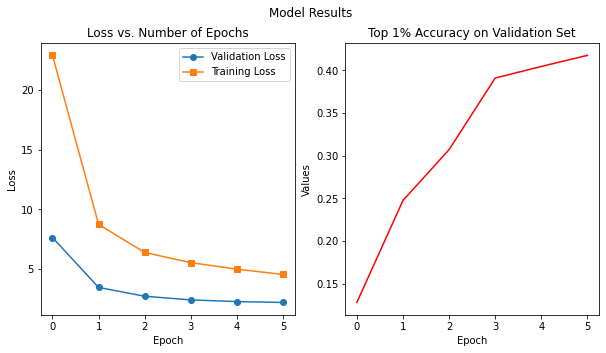

In [18]:
class Net3(BaseModule):
    def __init__(self):
        super(Net3, self).__init__()

        self.net = nn.Sequential(
            CausalConv1d(in_channels=1278, out_channels=128, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=128, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=128, out_channels=128, kernel_size=7, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=128, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=128, out_channels=128, kernel_size=20, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=128, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=128, out_channels=1, kernel_size=33, stride=1, dilation=1, groups=1, bias=True),
        )
    def forward(self, x):
        x = x.float()
#         print("Input shape", x.shape)
        res = self.net(x)
        temp = res[:,:, 150:]

        return temp.to(dtype=torch.float64)
    


model = to_device(Net3(), device)
history = [evaluate(model, val_loader)]
num_epochs = 6
opt_func = torch.optim.Adam
lr = 6e-5
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net3")

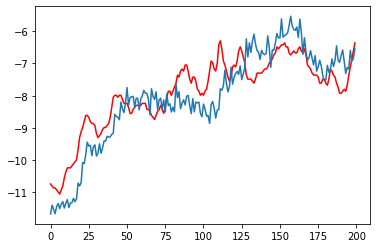

In [20]:

truth = []
preds = []

with torch.no_grad():
    count = 0
    lim = 15
    for batch in train_dl:
        res = model(batch[0].to("cuda"))
        res = res[:,0,:] 
        res = torch.flatten(res)
        preds+= res.tolist()
        
        truthVals = batch[1]
        truthVals = torch.flatten(truthVals)
        truth+= truthVals.float()
        count+=1

        if count > lim:
            break
    
plt.figure()
plt.plot(truth[:200], "-r")
plt.plot(preds[:200])
plt.show()

In [21]:
            
import numpy as np
a = np.array(preds[:90000], dtype=np.float16)
a.tofile('outputTCN4.csv',sep=',')

Epoch 1, Validation Loss: 9.4360, Validation Accuracy: 0.1981
Epoch 2, Validation Loss: 4.4539, Validation Accuracy: 0.2715
Epoch 3, Validation Loss: 3.0668, Validation Accuracy: 0.3126
Epoch 4, Validation Loss: 2.5715, Validation Accuracy: 0.3170
Epoch 5, Validation Loss: 2.3275, Validation Accuracy: 0.3930
Epoch 6, Validation Loss: 2.1947, Validation Accuracy: 0.4271
Epoch 7, Validation Loss: 2.1395, Validation Accuracy: 0.4057
Epoch 8, Validation Loss: 2.1424, Validation Accuracy: 0.3807


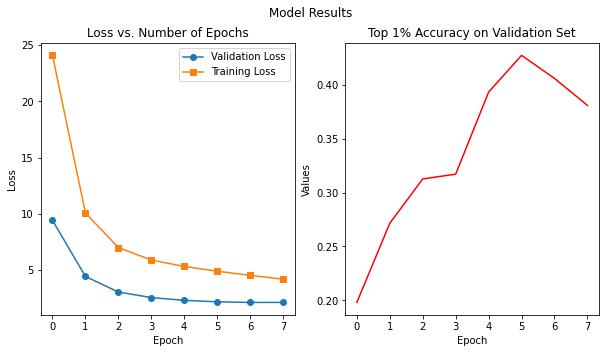

In [22]:
class Net4(BaseModule):
    def __init__(self):
        super(Net4, self).__init__()

        self.net = nn.Sequential(
            CausalConv1d(in_channels=1278, out_channels=256, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=256, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=256, out_channels=256, kernel_size=7, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=256, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=256, out_channels=256, kernel_size=20, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=256, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=256, out_channels=1, kernel_size=33, stride=1, dilation=1, groups=1, bias=True),
        )
    def forward(self, x):
        x = x.float()
#         print("Input shape", x.shape)
        res = self.net(x)
        temp = res[:,:, 150:]

        return temp.to(dtype=torch.float64)
    


model = to_device(Net4(), device)
history = [evaluate(model, val_loader)]
num_epochs = 8
opt_func = torch.optim.Adam
lr = 3e-5
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net4")

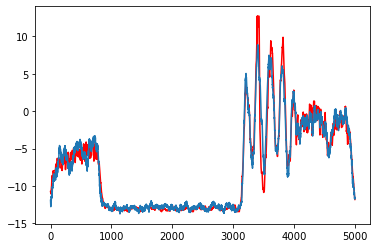

In [71]:
truth = []
preds = []

with torch.no_grad():
    count = 0
    lim = 15
    for batch in train_dl:
        res = model(batch[0].to("cuda"))
        res = res[:,0,:]
        res = torch.flatten(res)
        preds+= res.tolist()
        
        truthVals = batch[1]
        truthVals = torch.flatten(truthVals)
        truth+= truthVals.float()
        count+=1

        if count > lim:
            break
    
plt.figure()
plt.plot(truth[:5000], "-r")
plt.plot(preds[:5000])
plt.show()

In [76]:
# import numpy as np
# a = np.array(preds[:90000], dtype=np.float16)
# a.tofile('outputTCN5.csv',sep=',')

test = np.array(truth)
print(np.mean(test))
# c = 0
# for idx, item in enumerate(preds):
#     actual = truth[idx]
#     if abs(actual*0.01) <= abs(item) <= abs(actual*6):
#         c+=1
# print(c/len(preds))


-4.093751


Epoch 1, Validation Loss: 3.0362, Validation Accuracy: 0.2722
Epoch 2, Validation Loss: 2.4171, Validation Accuracy: 0.2949
Epoch 3, Validation Loss: 2.4935, Validation Accuracy: 0.2635
Epoch 4, Validation Loss: 2.3049, Validation Accuracy: 0.3447
Epoch 5, Validation Loss: 2.8353, Validation Accuracy: 0.2298
Epoch 6, Validation Loss: 3.1127, Validation Accuracy: 0.2100
Epoch 7, Validation Loss: 3.7439, Validation Accuracy: 0.1910
Epoch 8, Validation Loss: 2.8654, Validation Accuracy: 0.3134
Epoch 9, Validation Loss: 2.9957, Validation Accuracy: 0.2585
Epoch 10, Validation Loss: 2.4222, Validation Accuracy: 0.3717
Epoch 11, Validation Loss: 4.6155, Validation Accuracy: 0.1532


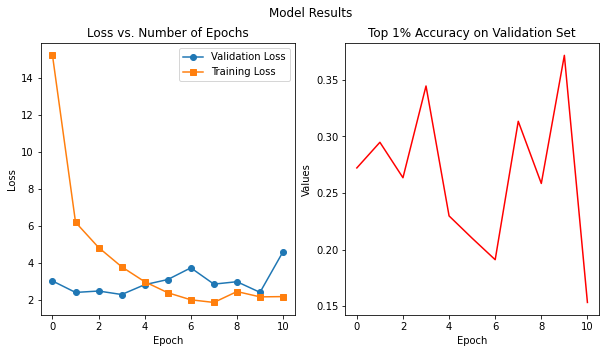

In [13]:

  
class Net5(BaseModule):
    def __init__(self):
        super(Net5, self).__init__()

        self.net = nn.Sequential(
          CausalConv1d(in_channels=1278, out_channels=1024, kernel_size=3, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=1024, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=1024, out_channels=1024, kernel_size=7, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=1024, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
             CausalConv1d(in_channels=1024, out_channels=1024, kernel_size=15, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=1024, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
          
            CausalConv1d(in_channels=1024, out_channels=1, kernel_size=39, stride=1, dilation=1, groups=1, bias=True),
        )
    def forward(self, x):
        x = x.float()
#         print("Input shape", x.shape)
        res = self.net(x)
        temp = res[:,:, 150:]

        return temp.to(dtype=torch.float64)
    



model = to_device(Net5(), device)
history = [evaluate(model, val_loader)]
num_epochs = 11
opt_func = torch.optim.Adam
lr = 4e-5
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net5")